<a href="https://colab.research.google.com/github/An-Dongsun/Melanoma-Detection/blob/feature%2FDL_model/DL_model_%EC%A0%9C%EC%9E%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 흑색종 이미지 분류 모델

- 지루성 각화증 → 387개
- 모반 → 8,570개
- 흑색종(양성) → 5,515개
- 흑색종(악성) → 5,119개
- 기저 세포 암종(BCC) → 516개

In [46]:
# 필요할 라이브러리 불러오기
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

# 전이학습 모델
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import EfficientNetB7, EfficientNetV2M, EfficientNetV2S, EfficientNetV2B3, EfficientNetV2B1


# 분류기 제작
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential, load_model

# 1. 데이터 불러오기

In [11]:
# 시드를 고정한다.
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/CP1 데이터'

train = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory,
        labels = "inferred",
        label_mode = 'categorical', # 레이블이 범주형 벡터로 인코딩됨을 의미
        class_names = {'BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)'},
        color_mode = "rgb",
        batch_size = 32,
        image_size = (256, 256),
        shuffle = True,
        seed = 42,
        validation_split = 0.1,
        subset = 'training',
        interpolation = "bilinear",
        follow_links = False,
        crop_to_aspect_ratio = False,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory,
        labels = "inferred",
        label_mode = 'categorical',
        class_names = {'BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)'},
        color_mode = "rgb",
        batch_size = 32,
        image_size = (256, 256),
        shuffle = True,
        seed = 42,
        validation_split = 0.1,
        subset = 'validation',
        interpolation = "bilinear",
        follow_links = False,
        crop_to_aspect_ratio = False,
)

Found 20053 files belonging to 5 classes.
Using 18048 files for training.
Found 20053 files belonging to 5 classes.
Using 2005 files for validation.


# Restnet50 전이학습


In [13]:
resnet = ResNet50(weights = 'imagenet', include_top = False)

In [14]:
# ResNet50 레이어들의 파라미터를 학습하도록 설정
for layer in resnet.layers:
    layer.trainable = True

In [15]:
# 모델에 출력층을 생성해준다.
x = resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
resnet_model = Model(resnet.input, predictions)

In [ ]:
# 모델의 전체적인 형태 확인해보기
resnet_model.summary()

In [16]:
# 모델 컴파일
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'Precision', 'Recall'])

In [18]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath = "resnet_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results = resnet_model.fit(train,
                            batch_size = batch_size,
                            epochs = epochs_max,
                            verbose = 1, 
                            validation_data = test,
                            callbacks = [early_stop, save_best])

Epoch 1/50
564/564 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8667 - precision: 0.8764 - recall: 0.8533
Epoch 1: val_loss improved from inf to 0.49240, saving model to resnet_model_best.hdf5
564/564 [==============================] - 1554s 3s/step - loss: 0.3928 - accuracy: 0.8667 - precision: 0.8764 - recall: 0.8533 - val_loss: 0.4924 - val_accuracy: 0.8160 - val_precision: 0.8277 - val_recall: 0.7885
Epoch 2/50
564/564 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 0.8820 - precision: 0.8883 - recall: 0.8728
Epoch 2: val_loss did not improve from 0.49240
564/564 [==============================] - 407s 717ms/step - loss: 0.3300 - accuracy: 0.8820 - precision: 0.8883 - recall: 0.8728 - val_loss: 9.8171 - val_accuracy: 0.2544 - val_precision: 0.2542 - val_recall: 0.2539
Epoch 3/50
564/564 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8969 - precision: 0.9011 - recall: 0.8920
Epoch 3: val_loss did not improve f

## 학습된 모델을 이용하여 테스트 & 저장

In [19]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc, test_precision, test_recall = resnet_model.evaluate(test, verbose = 1)

63/63 [==============================] - 21s 281ms/step - loss: 2.0106 - accuracy: 0.6993 - precision: 0.7018 - recall: 0.6973


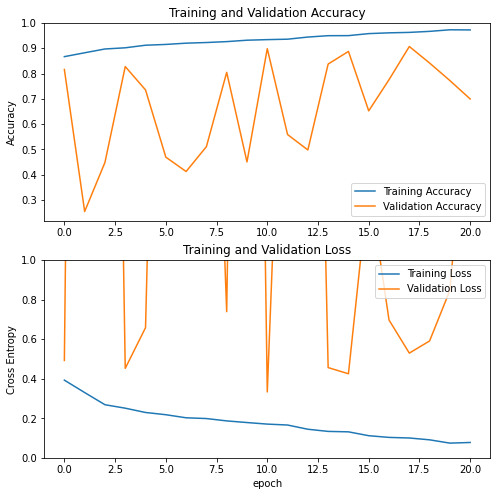

In [20]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
# 최고의 성능을 내는 파라미터를 불러온다.
resnet_model.load_weights(checkpoint_filepath)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc, test_precision, test_recall = resnet_model.evaluate(test, verbose = 1)

63/63 [==============================] - 21s 285ms/step - loss: 0.3332 - accuracy: 0.8983 - precision: 0.9067 - recall: 0.8868


In [22]:
# Model 저장
resnet_model.save('resnet_base_model.h5')

# InceptionResNetV2 이용한 전이학습

In [23]:
inception_resnet = tf.keras.applications.InceptionResNetV2(
                              include_top = False,
                              weights = "imagenet",
                              input_tensor = None,
                              input_shape = (256, 256, 3),
                              )

219070464/219055592 [==============================] - 1s 0us/step


In [24]:
# InceptionResNetV2 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in inception_resnet.layers:
    layer.trainable = True

In [25]:
# 모델에 출력층을 생성해준다.
x = inception_resnet.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
inception_resnet_model = Model(inception_resnet.input, predictions)

In [ ]:
inception_resnet_model.summary()

In [30]:
# 모델 컴파일
inception_resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'Precision', 'Recall'])

## OOM 때문에 batch size를 64로 줄였다.

In [31]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath2 = "inception_resnet_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath2,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results2 = inception_resnet_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
564/564 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8874 - precision: 0.8999 - recall: 0.8716
Epoch 1: val_loss improved from inf to 0.54179, saving model to inception_resnet_model_best.hdf5
564/564 [==============================] - 293s 482ms/step - loss: 0.3215 - accuracy: 0.8874 - precision: 0.8999 - recall: 0.8716 - val_loss: 0.5418 - val_accuracy: 0.8324 - val_precision: 0.8575 - val_recall: 0.8135
Epoch 2/50
564/564 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9148 - precision: 0.9202 - recall: 0.9092
Epoch 2: val_loss improved from 0.54179 to 0.22619, saving model to inception_resnet_model_best.hdf5
564/564 [==============================] - 273s 477ms/step - loss: 0.2224 - accuracy: 0.9148 - precision: 0.9202 - recall: 0.9092 - val_loss: 0.2262 - val_accuracy: 0.9162 - val_precision: 0.9175 - val_recall: 0.9157
Epoch 3/50
564/564 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9225 - prec

In [32]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc, test_precision, test_recall = inception_resnet_model.evaluate(test, verbose = 1)

63/63 [==============================] - 23s 304ms/step - loss: 0.2660 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347


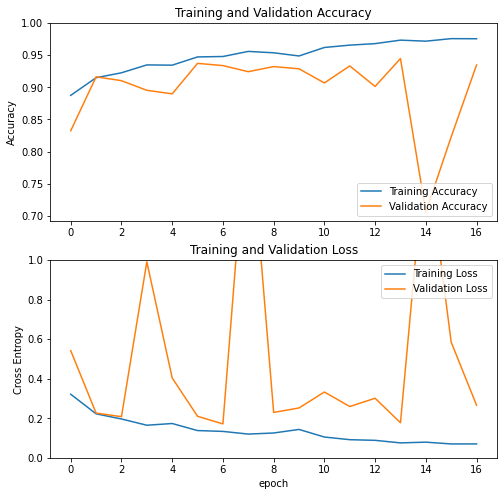

In [33]:
acc = results2.history['accuracy']
val_acc = results2.history['val_accuracy']

loss = results2.history['loss']
val_loss = results2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
inception_resnet_model.load_weights(checkpoint_filepath2)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc, test_precision, test_recall = inception_resnet_model.evaluate(test, verbose = 1)

63/63 [==============================] - 23s 301ms/step - loss: 0.1715 - accuracy: 0.9337 - precision: 0.9357 - recall: 0.9287


In [35]:
# Model 저장
inception_resnet_model.save('inception_resnet_model.h5')

# EfficientNetV2M

In [ ]:
EfficientNet_V2M = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
                   include_top = False,
                   weights = 'imagenet',
                   input_tensor = None,
                   input_shape = (256, 256, 3)
                   )

214212608/214201816 [==============================] - 1s 0us/step


In [ ]:
# EfficientNetV2M 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in EfficientNet_V2M.layers:
    layer.trainable = True

In [ ]:
# 모델에 출력층을 생성해준다.
x = EfficientNet_V2M.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
EfficientNet_V2M_model = Model(EfficientNet_V2M.input, predictions)

In [ ]:
EfficientNet_V2M_model.summary()

In [ ]:
# 모델 컴파일
EfficientNet_V2M_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## OOM 때문에 batch size를 32로 줄였다.

In [ ]:
# 이미지 파일들 불러오기
Dataset_directory = '/content/drive/MyDrive/CP1 데이터'

train = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory,
        labels = "inferred",
        label_mode = 'categorical', # 레이블이 범주형 벡터로 인코딩됨을 의미
        class_names = {'BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)'},
        color_mode = "rgb",
        batch_size = 32,
        image_size = (256, 256),
        shuffle = True,
        seed = 42,
        validation_split = 0.1,
        subset = 'training',
        interpolation = "bilinear",
        follow_links = False,
        crop_to_aspect_ratio = False,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
        Dataset_directory,
        labels = "inferred",
        label_mode = 'categorical',
        class_names = {'BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)'},
        color_mode = "rgb",
        batch_size = 32,
        image_size = (256, 256),
        shuffle = True,
        seed = 42,
        validation_split = 0.1,
        subset = 'validation',
        interpolation = "bilinear",
        follow_links = False,
        crop_to_aspect_ratio = False,
)

Found 20053 files belonging to 5 classes.
Using 18048 files for training.
Found 20053 files belonging to 5 classes.
Using 2005 files for validation.


In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath3 = "EfficientNet_V2M_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath3,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results3 = EfficientNet_V2M_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
564/564 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9167
Epoch 1: val_loss improved from inf to 0.25979, saving model to EfficientNet_V2M_model_best.hdf5
564/564 [==============================] - 350s 615ms/step - loss: 0.2224 - accuracy: 0.9167 - val_loss: 0.2598 - val_accuracy: 0.8913
Epoch 2/50
564/564 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9308
Epoch 2: val_loss improved from 0.25979 to 0.19290, saving model to EfficientNet_V2M_model_best.hdf5
564/564 [==============================] - 350s 613ms/step - loss: 0.1841 - accuracy: 0.9308 - val_loss: 0.1929 - val_accuracy: 0.9347
Epoch 3/50
564/564 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9328
Epoch 3: val_loss improved from 0.19290 to 0.16663, saving model to EfficientNet_V2M_model_best.hdf5
564/564 [==============================] - 350s 614ms/step - loss: 0.1769 - accuracy: 0.9328 - val_loss: 0.1666 - val_accuracy: 0.9332
Epoch 4/

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc = EfficientNet_V2M_model.evaluate(test, verbose = 1)

63/63 [==============================] - 26s 352ms/step - loss: 0.2748 - accuracy: 0.9466


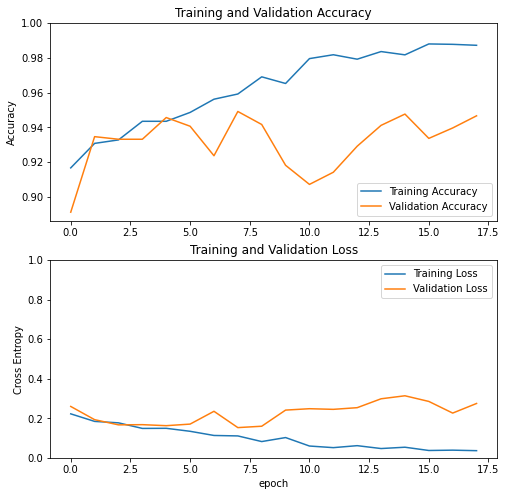

In [ ]:
acc = results3.history['accuracy']
val_acc = results3.history['val_accuracy']

loss = results3.history['loss']
val_loss = results3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
EfficientNet_V2M_model.load_weights(checkpoint_filepath3)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc = EfficientNet_V2M_model.evaluate(test, verbose = 1)

63/63 [==============================] - 27s 353ms/step - loss: 0.1527 - accuracy: 0.9491


In [ ]:
# Model 저장
EfficientNet_V2M_model.save('EfficientNet_V2M_model.h5')

# EfficientNetV2S

In [ ]:
EfficientNet_V2S = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
                   include_top = False,
                   weights = 'imagenet',
                   input_tensor = None,
                   input_shape = (256, 256, 3)
                   )

82436096/82420632 [==============================] - 1s 0us/step


In [ ]:
# EfficientNetV2S 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in EfficientNet_V2S.layers:
    layer.trainable = True

In [ ]:
# 모델에 출력층을 생성해준다.
x = EfficientNet_V2S.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
EfficientNet_V2S_model = Model(EfficientNet_V2S.input, predictions)

In [ ]:
EfficientNet_V2S_model.summary()

In [ ]:
# 모델 컴파일
EfficientNet_V2S_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'Precision','Recall'])

In [ ]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath4 = "EfficientNet_V2S_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath4,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results4 = EfficientNet_V2S_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
564/564 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9302 - precision: 0.9335 - recall: 0.9276
Epoch 1: val_loss improved from inf to 0.22140, saving model to EfficientNet_V2S_model_best.hdf5
564/564 [==============================] - 285s 499ms/step - loss: 0.1825 - accuracy: 0.9302 - precision: 0.9335 - recall: 0.9276 - val_loss: 0.2214 - val_accuracy: 0.9087 - val_precision: 0.9107 - val_recall: 0.9057
Epoch 2/50
564/564 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9370 - precision: 0.9386 - recall: 0.9347
Epoch 2: val_loss improved from 0.22140 to 0.16807, saving model to EfficientNet_V2S_model_best.hdf5
564/564 [==============================] - 296s 518ms/step - loss: 0.1685 - accuracy: 0.9370 - precision: 0.9386 - recall: 0.9347 - val_loss: 0.1681 - val_accuracy: 0.9342 - val_precision: 0.9457 - val_recall: 0.9302
Epoch 3/50
564/564 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9447 - prec

In [ ]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc, test_precision, test_recall = EfficientNet_V2S_model.evaluate(test, verbose = 1)

63/63 [==============================] - 26s 344ms/step - loss: 0.2927 - accuracy: 0.9377 - precision: 0.9376 - recall: 0.9372


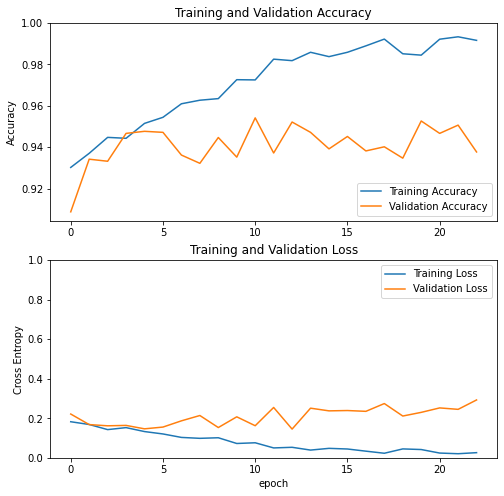

In [ ]:
acc = results4.history['accuracy']
val_acc = results4.history['val_accuracy']

loss = results4.history['loss']
val_loss = results4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
EfficientNet_V2S_model.load_weights(checkpoint_filepath4)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc, test_precision, test_recall = EfficientNet_V2S_model.evaluate(test, verbose = 1)

63/63 [==============================] - 26s 347ms/step - loss: 0.1452 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521


In [ ]:
# Model 저장
EfficientNet_V2S_model.save('EfficientNet_V2S_model.h5')

# EfficientNetV2B3

In [36]:
EfficientNet_V2B3 = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(
                   include_top = False,
                   weights = 'imagenet',
                   input_tensor = None,
                   input_shape = (256, 256, 3)
                   )

52617216/52606240 [==============================] - 0s 0us/step


In [37]:
# EfficientNetV2B3 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in EfficientNet_V2B3.layers:
    layer.trainable = True

In [38]:
# 모델에 출력층을 생성해준다.
x = EfficientNet_V2B3.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
EfficientNet_V2B3_model = Model(EfficientNet_V2B3.input, predictions)

In [ ]:
EfficientNet_V2B3_model.summary()

In [40]:
# 모델 컴파일
EfficientNet_V2B3_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'Precision','Recall'])

In [41]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath5 = "EfficientNet_V2B3_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath5,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results5 = EfficientNet_V2B3_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
564/564 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8876 - precision: 0.8977 - recall: 0.8768
Epoch 1: val_loss improved from inf to 0.17255, saving model to EfficientNet_V2B3_model_best.hdf5
564/564 [==============================] - 272s 448ms/step - loss: 0.3078 - accuracy: 0.8876 - precision: 0.8977 - recall: 0.8768 - val_loss: 0.1726 - val_accuracy: 0.9262 - val_precision: 0.9312 - val_recall: 0.9242
Epoch 2/50
564/564 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9246 - precision: 0.9271 - recall: 0.9208
Epoch 2: val_loss did not improve from 0.17255
564/564 [==============================] - 255s 445ms/step - loss: 0.2017 - accuracy: 0.9246 - precision: 0.9271 - recall: 0.9208 - val_loss: 0.2298 - val_accuracy: 0.9187 - val_precision: 0.9204 - val_recall: 0.9167
Epoch 3/50
564/564 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9348 - precision: 0.9364 - recall: 0.9324
Epoch 3: val_loss impr

In [42]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc, test_precision, test_recall = EfficientNet_V2B3_model.evaluate(test, verbose = 1)

63/63 [==============================] - 21s 285ms/step - loss: 0.2073 - accuracy: 0.9476 - precision: 0.9476 - recall: 0.9476


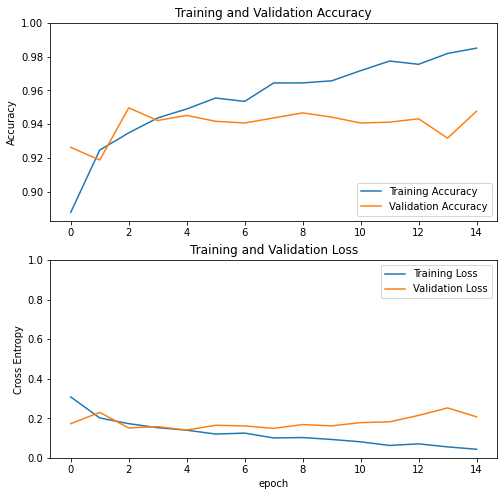

In [43]:
acc = results5.history['accuracy']
val_acc = results5.history['val_accuracy']

loss = results5.history['loss']
val_loss = results5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
EfficientNet_V2B3_model.load_weights(checkpoint_filepath5)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc, test_precision, test_recall = EfficientNet_V2B3_model.evaluate(test, verbose = 1)

63/63 [==============================] - 21s 283ms/step - loss: 0.1406 - accuracy: 0.9451 - precision: 0.9455 - recall: 0.9431


In [45]:
# Model 저장
EfficientNet_V2B3_model.save('EfficientNet_V2B3_model.h5')

# EfficientNetV2B1

In [47]:
EfficientNet_V2B1 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
                   include_top = False,
                   weights = 'imagenet',
                   input_tensor = None,
                   input_shape = (256, 256, 3)
                   )

28467200/28456008 [==============================] - 0s 0us/step


In [48]:
# EfficientNetV2B1 레이어들의 파라미터를 새로운 데이터에 맞게 학습하도록 설정
for layer in EfficientNet_V2B1.layers:
    layer.trainable = True

In [49]:
# 모델에 출력층을 생성해준다.
x = EfficientNet_V2B1.output
x = GlobalAveragePooling2D()(x)
# 다중 분류 모델을 만들어준다.
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x) # 출력층을 설계한다.
EfficientNet_V2B1_model = Model(EfficientNet_V2B1.input, predictions)

In [50]:
EfficientNet_V2B1_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  0          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [51]:
# 모델 컴파일
EfficientNet_V2B1_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'Precision','Recall'])

In [52]:
# 학습시킨 데이터를 저장시키기 위한 코드다. 
checkpoint_filepath6 = "EfficientNet_V2B1_model_best.hdf5"

# early stopping
# val_loss 모니터링, patience = 10 → 연속적으로 10번이나 값이 나아지지 않으면 조기 종료
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath6,
                                            monitor = 'val_loss',
                                            verbose = 1,
                                            save_best_only = True,
                                            save_weights_only = True,
                                            mode = 'auto',
                                            save_freq = 'epoch',
                                            options = None)

# 변수 설정을 따로 하는 방법을 적용하기 위한 코드입니다. 
batch_size = 32
epochs_max = 50

# 모델 학습
# 위에서 설정한 batch_size, epochs_max 그대로 가져와서 사용하기
results6 = EfficientNet_V2B1_model.fit(train,
                                      batch_size = batch_size,
                                      epochs = epochs_max,
                                      verbose = 1,
                                      validation_data = test,
                                      callbacks = [early_stop, save_best])

Epoch 1/50
564/564 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.9006 - precision: 0.9094 - recall: 0.8907
Epoch 1: val_loss improved from inf to 0.18672, saving model to EfficientNet_V2B1_model_best.hdf5
564/564 [==============================] - 277s 462ms/step - loss: 0.2787 - accuracy: 0.9006 - precision: 0.9094 - recall: 0.8907 - val_loss: 0.1867 - val_accuracy: 0.9307 - val_precision: 0.9347 - val_recall: 0.9282
Epoch 2/50
564/564 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9278 - precision: 0.9309 - recall: 0.9236
Epoch 2: val_loss improved from 0.18672 to 0.16524, saving model to EfficientNet_V2B1_model_best.hdf5
564/564 [==============================] - 259s 453ms/step - loss: 0.1914 - accuracy: 0.9278 - precision: 0.9309 - recall: 0.9236 - val_loss: 0.1652 - val_accuracy: 0.9411 - val_precision: 0.9416 - val_recall: 0.9411
Epoch 3/50
564/564 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9350 - pr

In [53]:
# 학습된 모델을 이용하여 테스트하는 코드
test_loss, test_acc, test_precision, test_recall = EfficientNet_V2B1_model.evaluate(test, verbose = 1)

63/63 [==============================] - 21s 282ms/step - loss: 0.3799 - accuracy: 0.9252 - precision: 0.9274 - recall: 0.9237


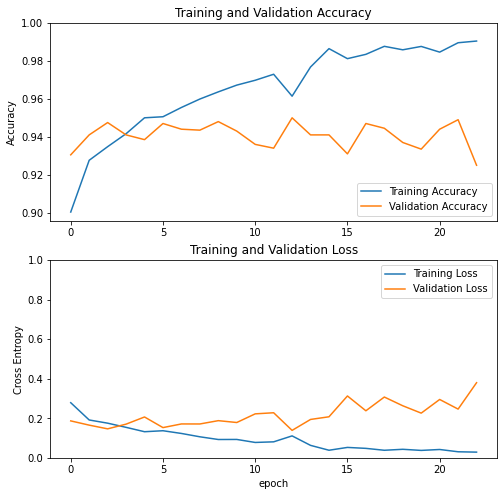

In [54]:
acc = results6.history['accuracy']
val_acc = results6.history['val_accuracy']

loss = results6.history['loss']
val_loss = results6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
EfficientNet_V2B1_model.load_weights(checkpoint_filepath6)

# best model을 이용한 테스트 데이터 예측 정확도 재확인 코드
test_loss, test_acc, test_precision, test_recall = EfficientNet_V2B1_model.evaluate(test, verbose = 1)

63/63 [==============================] - 21s 280ms/step - loss: 0.1387 - accuracy: 0.9501 - precision: 0.9511 - recall: 0.9501


In [56]:
# Model 저장
EfficientNet_V2B1_model.save('EfficientNet_V2B1_model.h5')